In [1]:
import pyvips
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from scipy.stats import pearsonr
import cv2
import torch
import pandas as pd
import json
from sklearn.metrics import f1_score
import numpy as np
from pathlib import Path
import albumentations as A

from tqdm import tqdm

import sys
sys.path.append("../")
from src.dataset import get_width_height, get_augmentations, NormalizationLayer, TileSlideDataset, get_effective_width_height,\
        TileImg2ImgSlideDataset, get_input_mean_std
from src.generators import get_generator
from src.metrics import CellMetrics

/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/local/anaconda3/envs/orion/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
checkpoint_dir = "/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora"
#checkpoint_dir = "/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora"

checkpoint_path = str(Path(checkpoint_dir) / "model.weights.ckpt")
config_path = str(Path(checkpoint_dir) / "config.yaml")

cfg = OmegaConf.load(config_path)

In [3]:
from timm.layers import resample_abs_pos_embed

def resize_pos_embed_statedict(state_dict, model, img_size, vit_key):
    if img_size != 224:
        old_pos_embed = state_dict[vit_key + '.pos_embed']
        pos_embed = resample_abs_pos_embed(
            old_pos_embed,
            new_size=model.patch_embed.grid_size,
            num_prefix_tokens=0 if model.no_embed_class \
                else model.num_prefix_tokens,
        )
        state_dict[vit_key +'.pos_embed'] = pos_embed
    return state_dict

def get_generator_state_dict(state_dict):
    generator_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("generator."):
            generator_state_dict[k.replace("generator.", "")] = v
    return generator_state_dict

In [4]:
from PIL import Image, ImageEnhance
def improve_contrast_image(image):
    enhancer = ImageEnhance.Contrast(Image.fromarray(image))
    contrast_image = np.asarray(enhancer.enhance(2.0))
    return contrast_image

## ORION

In [ ]:
dataset_config_path = "../configs/data/orion.yaml"


if Path(dataset_config_path).exists():
    dataset_config = OmegaConf.load(dataset_config_path)
    for key in ["slide_dataframe_path", "train_dataframe_path", "val_dataframe_path", "test_dataframe_path"]:
        if key in dataset_config.data:
            cfg.data[key] = dataset_config.data[key]

slide_dataframe = pd.read_csv(cfg.data.slide_dataframe_path)
test_dataframe = pd.read_csv(cfg.data.test_dataframe_path)

In [ ]:
n_marker = len(cfg.data.targ_channel_names) - 1
logreg = torch.nn.Linear(n_marker, n_marker)
logreg_state_dict = torch.load(str(Path(checkpoint_dir) / "logreg.pth"), map_location="cpu")
logreg.load_state_dict(logreg_state_dict)
logreg.eval()

In [ ]:
width, height = get_width_height(test_dataframe)
width, height = get_effective_width_height(width, height, train=True)

spatial_augmentations = A.Compose([
    A.CenterCrop(width=256, height=256),
], additional_targets={"image_target": "image", "nuclei": "image"})

with open("../channel_stats.json", "r") as f:
    channel_stats = json.load(f)

channel_stats_rgb = get_input_mean_std(cfg, channel_stats["RGB"])
preprocess_input_fn = NormalizationLayer(channel_stats_rgb, mode="he")

dataset = TileImg2ImgSlideDataset(
        dataframe=test_dataframe, preprocess_input_fn=preprocess_input_fn,
        spatial_augmentations=spatial_augmentations, return_nuclei=True)

num_workers = 6
batch_size = 16
device = "cpu"
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, pin_memory=device!="cpu",
    shuffle=False, drop_last=False, num_workers=num_workers
)

he [[123.675 116.28  103.53 ]] [[58.395 57.12  57.375]]


In [ ]:
torch.cuda.empty_cache()


nc_out = len(cfg.data.targ_channel_names)
nc_in = 3
generator = get_generator(cfg.model.model_name, width, nc_in, nc_out, cfg).eval()

state_dict = torch.load(checkpoint_path, map_location="cpu")["state_dict"]
logreg_state_dict = {k.replace("logreg_layer.", ""): v for k, v in state_dict.items() if "logreg_layer." in k}
state_dict = get_generator_state_dict(state_dict)
if hasattr(generator, "encoder"):
    if hasattr(generator.encoder, "vit"):
        state_dict = resize_pos_embed_statedict(
            state_dict, generator.encoder.vit, width, "encoder.vit")
    elif hasattr(generator.encoder, "model"):
        if hasattr(generator.encoder.model, "pos_embed"):
            state_dict = resize_pos_embed_statedict(
                state_dict, generator.encoder.model, width, "encoder.model")

generator.load_state_dict(state_dict)

generator = generator.eval().cuda().half()

In [ ]:
marker_selected = ["CD3e_pos", "CD8a_pos"]
marker_names = [col.replace("_pos", "") for col in marker_selected]
idxs_channels = [cfg.data.targ_channel_names.index(col.replace("_pos", "")) for col in marker_selected]

Text(0.5, 1.0, 'Nuclei')

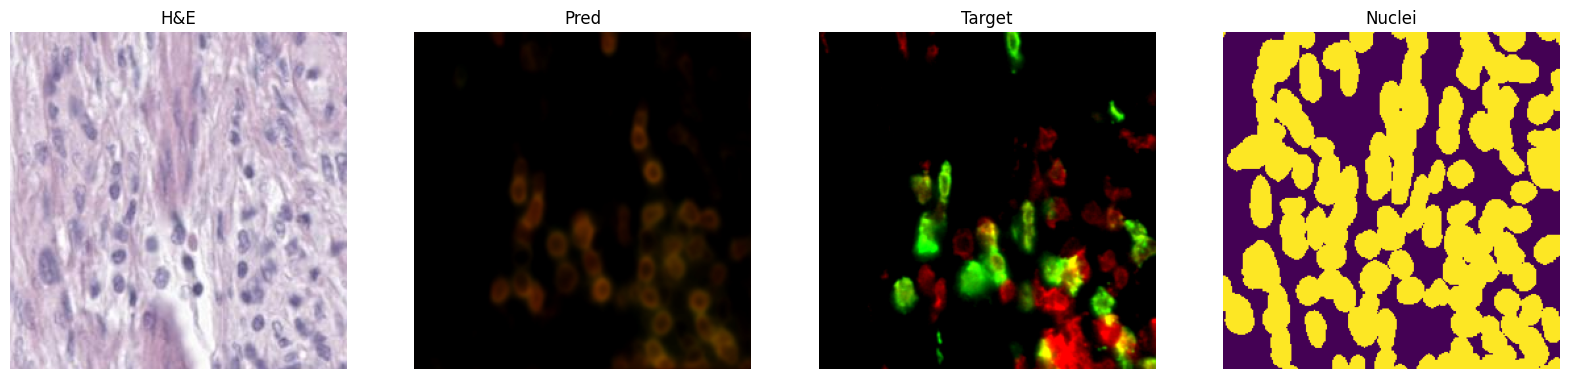

In [52]:
row_tile = test_dataframe.iloc[4035]

tile_he = cv2.cvtColor(cv2.imread(row_tile["image_path"]), cv2.COLOR_BGR2RGB)
tile_if = pyvips.Image.new_from_file(row_tile["target_path"]).numpy()[..., idxs_channels]
nuclei = cv2.imread(row_tile["nuclei_path"], cv2.IMREAD_ANYDEPTH)

central_crop = A.CenterCrop(256, 256)
tile_he = central_crop(image=tile_he)["image"]
tile_if = central_crop(image=tile_if)["image"]
nuclei = central_crop(image=nuclei)["image"]


x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()

with torch.inference_mode():
    out = generator(x.half()).float()
    out = (out.clamp(-0.9, 0.9) + 0.9) / 1.8
    out = np.uint8(out[0].cpu().permute((1, 2, 0)).numpy() * 255)

out = out[..., idxs_channels]
out = np.dstack((out, np.zeros_like(out[..., 0])))
tile_if = np.dstack((tile_if, np.zeros_like(tile_if[..., 0])))
#norm_scale = np.percentile(tile_if, 99, axis=(0, 1), keepdims=True) / np.percentile(out, 99, axis=(0, 1), keepdims=True)
#out_scale = np.uint8(np.clip(np.float32(out * norm_scale), 0., 255))

tile_if = improve_contrast_image(tile_if)
out_scale = improve_contrast_image(out)


fig, axis = plt.subplots(1, 4, figsize=(20, 20))
axis[0].imshow(tile_he)
axis[0].axis('off')
axis[0].set_title('H&E')

axis[1].imshow(out_scale)
axis[1].axis('off')
axis[1].set_title('Pred')

axis[2].imshow(tile_if)
axis[2].axis('off')
axis[2].set_title('Target')

axis[3].imshow(nuclei)
axis[3].axis('off')
axis[3].set_title('Nuclei')


In [53]:
cell_metrics = CellMetrics(slide_dataframe, marker_names=cfg.data.targ_channel_names, min_area=20)
x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()
with torch.inference_mode():
    pred = generator(x.half()).cpu().float()
    cell_metrics.update(pred, torch.from_numpy(nuclei).unsqueeze(0), [row_tile["in_slide_name"]])


test_cell_dataframe = cell_metrics.get_dataframe_cell_pred_target()

columns_preds = [f"{col}_logreg_pred" for col in cell_metrics.marker_cols]

with torch.inference_mode():
    cell_logits = logreg(torch.from_numpy(test_cell_dataframe[cell_metrics.marker_pred_cols].values).float())
    cell_preds = torch.sigmoid(cell_logits) > 0.5
    cell_preds = cell_preds.numpy()

test_cell_dataframe[columns_preds] = cell_preds

cell_metrics.reset()

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

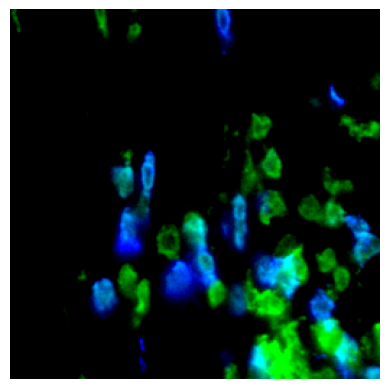

In [54]:
from skimage.exposure import equalize_adapthist

tile_if_contrast = np.zeros_like(out)
tile_if_contrast[..., 1] = np.uint8(equalize_adapthist(tile_if[..., 0])*255)
tile_if_contrast[..., 2] = np.uint8(equalize_adapthist(tile_if[..., 1])*255)
plt.imshow(tile_if_contrast)
plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

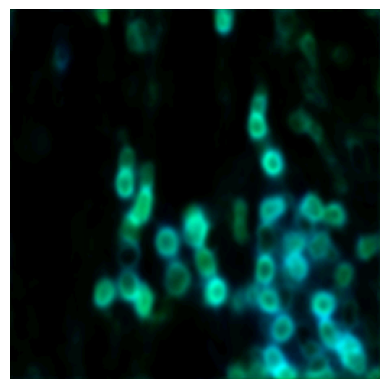

In [55]:
from skimage.exposure import equalize_adapthist

out_contrast = np.zeros_like(out)
out_contrast[..., 1] = np.uint8(equalize_adapthist(out[..., 0])*255)
out_contrast[..., 2] = np.uint8(equalize_adapthist(out[..., 1])*255)
plt.imshow(out_contrast)
plt.axis('off')

In [66]:
cell_dataframe_roi = test_cell_dataframe


mask_pred_cd8 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[1]}_pos_logreg_pred"]]["label"].values)
nuclei_pred_cd8 = np.where(mask_pred_cd8, nuclei, 0)
mask_pred_cd3 =  np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[0]}_pos_logreg_pred"]]["label"].values)
nuclei_pred_cd3 = np.where(mask_pred_cd3, nuclei, 0)
nuclei_pred_other = np.where(~mask_pred_cd3 & ~mask_pred_cd8, nuclei, 0)


mask_pos_cd8 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[1]}_pos"]]["label"].values)
nuclei_pos_cd8 = np.where(mask_pos_cd8, nuclei, 0)
mask_pos_cd3 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[0]}_pos"]]["label"].values)
nuclei_pos_cd3 = np.where(mask_pos_cd3, nuclei, 0)
nuclei_pos_other = np.where(~mask_pos_cd3 & ~mask_pos_cd8, nuclei, 0)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

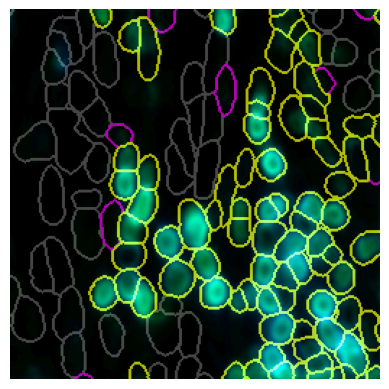

In [69]:
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_dilation, disk


image_vis_pred = out_contrast.copy()

contour_cd8 = find_boundaries(nuclei_pred_cd8, mode='thick')
#contour_cd8 = binary_dilation(contour_cd8, disk(1))
contour_cd3 = find_boundaries(nuclei_pred_cd3, mode='thick')

contour_other = find_boundaries(nuclei_pred_other, mode='thick')
#contour_cd3 = binary_dilation(contour_cd3, disk(1))
contour = np.zeros_like(image_vis_pred)
contour[contour_other] = [100, 100, 100]
contour[contour_cd3] = [255, 0, 255]
contour[contour_cd8] = [255, 255, 0]

image_vis_pred = cv2.addWeighted(image_vis_pred, 1, contour, 0.7, 0)

plt.imshow(image_vis_pred)
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

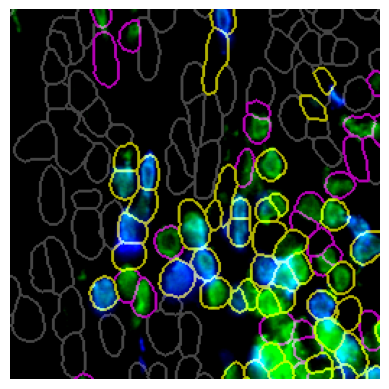

In [70]:
image_vis_target = tile_if_contrast.copy()

contour_cd8 = find_boundaries(nuclei_pos_cd8, mode='thick')
#contour_cd8 = binary_dilation(contour_cd8, disk(1))
contour_cd3 = find_boundaries(nuclei_pos_cd3, mode='thick')
#contour_cd3 = binary_dilation(contour_cd3, disk(1))
contour_other = find_boundaries(nuclei_pos_other, mode='thick')

contour = np.zeros_like(image_vis_target)
contour[contour_other] = [100, 100, 100]
contour[contour_cd3] = [255, 0, 255]
contour[contour_cd8] = [255, 255, 0]

image_vis_target = cv2.addWeighted(image_vis_target, 1, contour, 0.70, 0)

plt.imshow(image_vis_target)
plt.axis("off")

In [72]:
cv2.imwrite("/root/workdir/figure/tile_orion_he.png", cv2.cvtColor(tile_he, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_pred.png", cv2.cvtColor(image_vis_pred, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_orion_target.png", cv2.cvtColor(image_vis_target, cv2.COLOR_BGR2RGB))

True

## HEMIT

In [5]:
dataset_config_path = "../configs/data/hemit.yaml"


if Path(dataset_config_path).exists():
    dataset_config = OmegaConf.load(dataset_config_path)
    for key in ["slide_dataframe_path", "train_dataframe_path", "val_dataframe_path", "test_dataframe_path"]:
        if key in dataset_config.data:
            cfg.data[key] = dataset_config.data[key]

slide_dataframe = pd.read_csv(cfg.data.slide_dataframe_path)
test_dataframe = pd.read_csv(cfg.data.test_dataframe_path)

In [7]:
n_marker = len(cfg.data.targ_channel_names) - 1
logreg = torch.nn.Linear(n_marker, 2)
logreg_state_dict = torch.load(str(Path(checkpoint_dir) / "hemit_logreg.pth"), map_location="cpu")
logreg.load_state_dict(logreg_state_dict)
logreg.eval()

Linear(in_features=15, out_features=2, bias=True)

In [8]:
width, height = get_width_height(test_dataframe)
width, height = get_effective_width_height(width, height, train=True)

spatial_augmentations = None

with open("../channel_stats.json", "r") as f:
    channel_stats = json.load(f)

channel_stats_rgb = get_input_mean_std(cfg, channel_stats["RGB"])
preprocess_input_fn = NormalizationLayer(channel_stats_rgb, mode="he")

dataset = TileImg2ImgSlideDataset(
        dataframe=test_dataframe, preprocess_input_fn=preprocess_input_fn,
        spatial_augmentations=spatial_augmentations, return_nuclei=True)

num_workers = 6
batch_size = 16
device = "cpu"
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, pin_memory=device!="cpu",
    shuffle=False, drop_last=False, num_workers=num_workers
)

he [[123.675 116.28  103.53 ]] [[58.395 57.12  57.375]]


In [9]:
torch.cuda.empty_cache()


nc_out = len(cfg.data.targ_channel_names)
nc_in = 3
generator = get_generator(cfg.model.model_name, width//2, nc_in, nc_out, cfg).eval()

state_dict = torch.load(checkpoint_path, map_location="cpu")["state_dict"]
logreg_state_dict = {k.replace("logreg_layer.", ""): v for k, v in state_dict.items() if "logreg_layer." in k}
state_dict = get_generator_state_dict(state_dict)
if hasattr(generator, "encoder"):
    if hasattr(generator.encoder, "vit"):
        state_dict = resize_pos_embed_statedict(
            state_dict, generator.encoder.vit, width, "encoder.vit")
    elif hasattr(generator.encoder, "model"):
        if hasattr(generator.encoder.model, "pos_embed"):
            state_dict = resize_pos_embed_statedict(
                state_dict, generator.encoder.model, width, "encoder.model")

generator.load_state_dict(state_dict)

generator = generator.eval().cuda().half()

In [10]:
marker_selected = ["Pan-CK_pos", "CD3e_pos"]
marker_names = [col.replace("_pos", "") for col in marker_selected]
idxs_channels = [cfg.data.targ_channel_names.index(col.replace("_pos", "")) for col in marker_selected]

In [11]:
idxs_channels

[14, 10]

Text(0.5, 1.0, 'Nuclei')

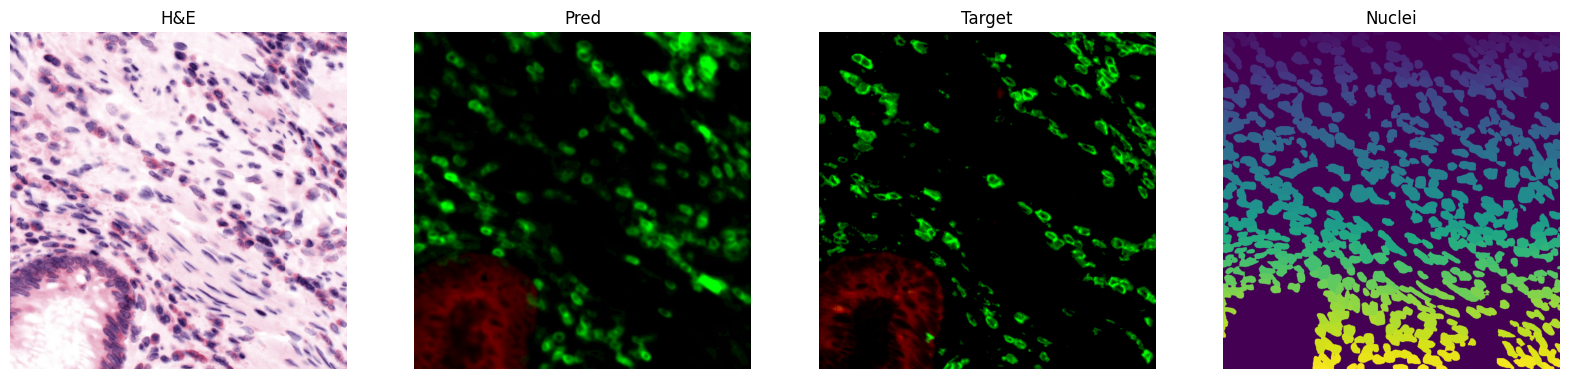

In [24]:
row_tile = test_dataframe.iloc[857]

tile_he = cv2.cvtColor(cv2.imread(row_tile["image_path"]), cv2.COLOR_BGR2RGB)
tile_if = cv2.cvtColor(cv2.imread(row_tile["target_path"]), cv2.COLOR_BGR2RGB)[..., [0, 1]]
nuclei = cv2.imread(row_tile["nuclei_path"], cv2.IMREAD_ANYDEPTH)


x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()

with torch.inference_mode():
    x = torch.nn.functional.interpolate(x, (width //2, height//2), mode="bilinear")
    out = generator(x.half()).float()
    out = torch.nn.functional.interpolate(out, (width, height), mode="bilinear")
    out = (out.clamp(-0.9, 0.9) + 0.9) / 1.8
    out = np.uint8(out[0].cpu().permute((1, 2, 0)).numpy() * 255)

out = out[..., idxs_channels]
norm_scale = np.percentile(tile_if, 99, axis=(0, 1), keepdims=True) / np.percentile(out, 99, axis=(0, 1), keepdims=True)
out = np.uint8(np.clip(np.float32(out * norm_scale), 0., 255))
out = np.dstack((out, np.zeros_like(out[..., 0])))

tile_if = np.dstack((tile_if, np.zeros_like(tile_if[..., 0])))
#norm_scale = np.percentile(tile_if, 99, axis=(0, 1), keepdims=True) / np.percentile(out, 99, axis=(0, 1), keepdims=True)
#out_scale = np.uint8(np.clip(np.float32(out * norm_scale), 0., 255))

tile_if = improve_contrast_image(tile_if)
out_scale = improve_contrast_image(out)


fig, axis = plt.subplots(1, 4, figsize=(20, 20))
axis[0].imshow(tile_he)
axis[0].axis('off')
axis[0].set_title('H&E')

axis[1].imshow(out_scale)
axis[1].axis('off')
axis[1].set_title('Pred')

axis[2].imshow(tile_if)
axis[2].axis('off')
axis[2].set_title('Target')

axis[3].imshow(nuclei)
axis[3].axis('off')
axis[3].set_title('Nuclei')


In [25]:
cell_metrics = CellMetrics(slide_dataframe, marker_names=cfg.data.targ_channel_names, min_area=20)
x = torch.from_numpy(preprocess_input_fn(tile_he)).permute((2, 0, 1)).unsqueeze(dim=0).cuda()
with torch.inference_mode():
    x = torch.nn.functional.interpolate(x, (width //2, height//2), mode="bilinear")
    pred = generator(x.half()).cpu().float()
    pred = torch.nn.functional.interpolate(pred, (width, height), mode="bilinear")
    cell_metrics.update(pred, torch.from_numpy(nuclei).unsqueeze(0), [row_tile["in_slide_name"]])


marker_names = ["Pan-CK", "CD3"]
cell_metrics.marker_cols = marker_names
cell_metrics.marker_cols = [f"{marker_name}_pos" for marker_name in marker_names]
test_cell_dataframe = cell_metrics.get_dataframe_cell_pred_target()

columns_preds = [f"{col}_logreg_pred" for col in cell_metrics.marker_cols]

with torch.inference_mode():
    cell_logits = logreg(torch.from_numpy(test_cell_dataframe[cell_metrics.marker_pred_cols].values).float())
    cell_preds = torch.sigmoid(cell_logits) > 0.5
    cell_preds = cell_preds.numpy()

test_cell_dataframe[columns_preds] = cell_preds

cell_metrics.reset()

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

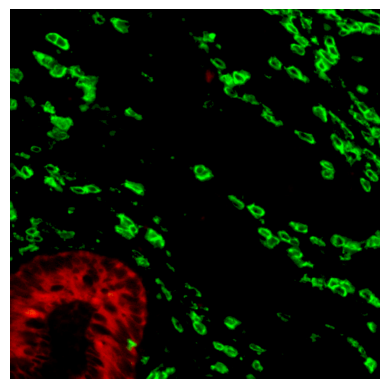

In [26]:
from skimage.exposure import equalize_adapthist

tile_if_contrast = np.zeros_like(out)
tile_if_contrast[..., 0] = np.uint8(equalize_adapthist(tile_if[..., 0])*255)
tile_if_contrast[..., 1] = np.uint8(equalize_adapthist(tile_if[..., 1])*255)
plt.imshow(tile_if_contrast)
plt.axis('off')

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

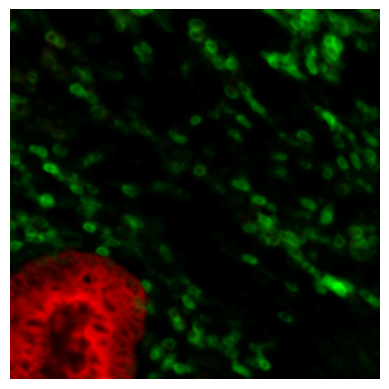

In [27]:
from skimage.exposure import equalize_adapthist

out_contrast = np.zeros_like(out)
out_contrast[..., 0] = np.uint8(equalize_adapthist(out[..., 0])*255)
out_contrast[..., 1] = np.uint8(equalize_adapthist(out[..., 1])*255)
plt.imshow(out_contrast)
plt.axis('off')

In [28]:
cell_dataframe_roi = test_cell_dataframe


mask_pred_cd8 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[1]}_pos_logreg_pred"]]["label"].values)
nuclei_pred_cd8 = np.where(mask_pred_cd8, nuclei, 0)
mask_pred_cd3 =  np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[0]}_pos_logreg_pred"]]["label"].values)
nuclei_pred_cd3 = np.where(mask_pred_cd3, nuclei, 0)
nuclei_pred_other = np.where(~mask_pred_cd3 & ~mask_pred_cd8, nuclei, 0)


mask_pos_cd8 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[1]}_pos"]]["label"].values)
nuclei_pos_cd8 = np.where(mask_pos_cd8, nuclei, 0)
mask_pos_cd3 = np.isin(nuclei, cell_dataframe_roi[cell_dataframe_roi[f"{marker_names[0]}_pos"]]["label"].values)
nuclei_pos_cd3 = np.where(mask_pos_cd3, nuclei, 0)
nuclei_pos_other = np.where(~mask_pos_cd3 & ~mask_pos_cd8, nuclei, 0)

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

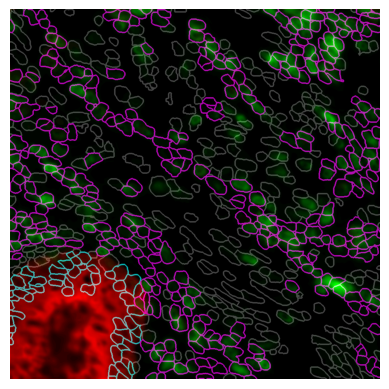

In [29]:
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_dilation, disk


image_vis_pred = out_contrast.copy()

contour_cd8 = find_boundaries(nuclei_pred_cd8, mode='thick')
contour_cd8 = binary_dilation(contour_cd8, disk(1))
contour_cd3 = find_boundaries(nuclei_pred_cd3, mode='thick')
contour_cd3 = binary_dilation(contour_cd3, disk(1))

contour_other = find_boundaries(nuclei_pred_other, mode='thick')
contour_other = binary_dilation(contour_other, disk(1))


contour = np.zeros_like(image_vis_pred)
contour[contour_other] = [100, 100, 100]
contour[contour_cd3] = [0, 255, 255]
contour[contour_cd8] = [255, 0, 255]

image_vis_pred = cv2.addWeighted(image_vis_pred, 1, contour, 0.7, 0)

plt.imshow(image_vis_pred)
plt.axis("off")

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

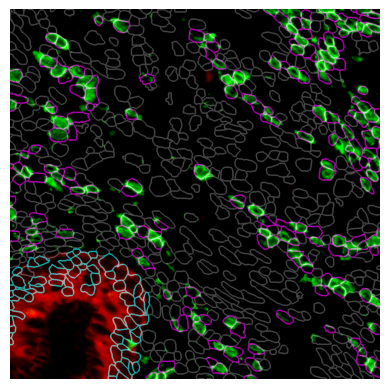

In [30]:
image_vis_target = tile_if_contrast.copy()

contour_cd8 = find_boundaries(nuclei_pos_cd8, mode='thick')
contour_cd8 = binary_dilation(contour_cd8, disk(1))
contour_cd3 = find_boundaries(nuclei_pos_cd3, mode='thick')
contour_cd3 = binary_dilation(contour_cd3, disk(1))
contour_other = find_boundaries(nuclei_pos_other, mode='thick')
contour_other = binary_dilation(contour_other, disk(1))

contour = np.zeros_like(image_vis_target)
contour[contour_other] = [100, 100, 100]
contour[contour_cd3] = [0, 255, 255]
contour[contour_cd8] = [255, 0, 255]

image_vis_target = cv2.addWeighted(image_vis_target, 1, contour, 0.70, 0)

plt.imshow(image_vis_target)
plt.axis("off")

In [34]:
cv2.imwrite("/root/workdir/figure/tile_hemit_he.png", cv2.cvtColor(tile_he, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_hemit_pred.png", cv2.cvtColor(image_vis_pred, cv2.COLOR_BGR2RGB))
cv2.imwrite("/root/workdir/figure/tile_hemit_target.png", cv2.cvtColor(image_vis_target, cv2.COLOR_BGR2RGB))

True

## Identify tile idx

In [83]:
dataset_identification = TileImg2ImgSlideDataset(
        dataframe=test_dataframe, preprocess_input_fn=None,
        spatial_augmentations=spatial_augmentations, return_nuclei=True)

num_workers = 6
batch_size = 16
device = "cpu"
dataloader_identification = torch.utils.data.DataLoader(
    dataset_identification, batch_size=batch_size, pin_memory=device!="cpu",
    shuffle=False, drop_last=False, num_workers=num_workers
)

In [84]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

mobilenet = mobilenet_v3_small(weights="DEFAULT").cuda().eval()
mobilenet.classifier = nn.Sequential()

preprocessing = MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

In [85]:
all_embeddings = []
for batch in tqdm(dataloader_identification, total=len(dataloader_identification)):
    image = preprocessing(batch["image"])
    with torch.inference_mode():
        embeddings = mobilenet(image.cuda()).cpu().numpy()
    all_embeddings.append(np.float16(embeddings))

all_embeddings = np.vstack(all_embeddings)

100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


In [86]:
img_target = cv2.imread("/root/workdir/AIDA-ImagetoImageHE2IF/figures/tile_hemit_he.png")
img_target = cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB)
img_target = torch.permute(torch.from_numpy(img_target), (2, 0, 1))
img_target = preprocessing(img_target.unsqueeze(dim=0))
with torch.inference_mode():
    embedding_target = mobilenet(img_target.cuda()).cpu().numpy()[0]

In [87]:
np.linalg.norm(all_embeddings - embedding_target, axis=1).argmin()

np.int64(384)

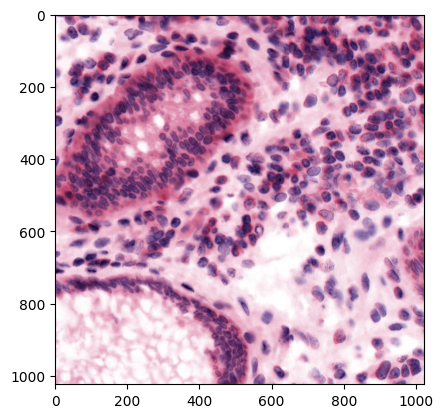

In [88]:
plt.imshow(dataset_identification[384]["image"].permute((1, 2, 0)).numpy())